# Example 13 LH2 exciton delocalization

- References
  - [Cupellini, Lorenzo, et al. "An ab initio description of the excitonic properties of LH2 and their temperature dependence." The Journal of Physical Chemistry B 120.44 (2016): 11348-11359.](https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.6b06585)
  - [Shibl, Mohamed F., et al. "Multilayer-MCTDH approach to the energy transfer dynamics in the LH2 antenna complex." Journal of Physics B: Atomic, Molecular and Optical Physics 50.18 (2017): 184001.](https://iopscience.iop.org/article/10.1088/1361-6455/aa8374/meta)

In [1]:
import platform
import sys

import pytdscf

print(sys.version)
print(f"pytdscf version = {pytdscf.__version__}")
print(platform.platform())

3.12.2 (main, Feb 25 2024, 04:38:01) [Clang 17.0.6 ]
pytdscf version = 1.1.0
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39


In [2]:
!uv pip install seaborn # enebale as needed


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sympy
from pympo import AssignManager, OpSite, SumOfProducts

from pytdscf import (
    BasInfo,
    Boson,
    Exciton,
    Model,
    Simulator,
    TensorHamiltonian,
    TensorOperator,
    units,
)

Using Python 3.12.2 environment at: /home/hinom/GitHub/PyTDSCF-dev/.venv
Audited 1 package in 2ms


## Model Hamiltonian

![](../pic/lh2-mps-Page-2.drawio.svg)

$$
H = H_{\text{sys}} + H_{\text{bath}} + H_{\text{sys-bath}}
$$

where $H_{\text{sys}}$ is a system Hamiltonian consists of $3\times 9=27$ sites. The coupling parameters and assignments to the MPS lattice are as follows;


| Category       | Type    | E (cm⁻¹) |
|---------------|--------|---------|
| site energy (MMPol) | B850α | 13089 |
|               | B850β | 13051 |
|               | B800γ | 13350 |
| intra-B850    | Vₐᵦ¹  | 317     |
|               | Vₐᵦ²  | 339     |
|               | Vₐᵦ³  | 20      |
|               | Vₐᵦ⁺  | 18      |
|               | Vₐₐˡ  | -66     |
|               | Vₐₐ²  | -10     |
|               | Vᵦᵦˡ  | -51     |
|               | Vᵦᵦ²  | <10     |
| B850–B800    | Vₐᵧˡ  | 42      |
|               | Vₐᵧ²  | -16     |
|               | Vᵦᵧˡ  | -10     |
|               | Vᵦᵧ²  | <10     |
| intra-B800   | Vᵧᵧˡ  | -32     |

![](../pic/lh2-mps-Page-1.drawio.svg)

$H_{\text{bath}}$ is a bath Hamiltonian consists of $27 \times 26= 702$ sites in harmonic form and
 $H_{\text{sys-bath}}$ is a system-bath coupling in a linear vibronic coupling form;

$$
H_{\text{sys-bath}}+H_{\text{bath}} = 
\sum_{\xi,i} \frac{\hbar\omega_i}{2} \left(\hat{P}_i^2 + \left(\hat{Q}_i-\sqrt{2S_i}\hat{a}_\xi^\dagger\hat{a}_\xi\right)^2\right)
$$

The parameters of bath are as follows;


| ωξ (cm⁻¹) | Sξ   | Type        |
|-----------|------|------------|
| 23.3      | 0.017 | Vibrational |
| 88.2      | 0.020 | Vibrational |
| 203.3     | 0.056 | Vibrational |
| 361.6     | 0.044 | Vibrational |
| 562.6     | 0.021 | Vibrational |
| 748.2     | 0.050 | Vibrational |
| 915.7     | 0.051 | Vibrational |
| 25        | 0.106 | Phonon      |
| 50        | 0.081 | Phonon      |
| 75        | 0.065 | Phonon      |
| 100       | 0.050 | Phonon      |
| 125       | 0.037 | Phonon      |
| 150       | 0.028 | Phonon      |
| 175       | 0.021 | Phonon      |
| 200       | 0.016 | Phonon      |
| 225       | 0.013 | Phonon      |
| 250       | 0.010 | Phonon      |
| 275       | 0.008 | Phonon      |
| 300       | 0.007 | Phonon      |
| 325       | 0.006 | Phonon      |
| 350       | 0.005 | Phonon      |
| 375       | 0.004 | Phonon      |
| 400       | 0.004 | Phonon      |
| 425       | 0.003 | Phonon      |
| 450       | 0.003 | Phonon      |
| 475       | 0.003 | Phonon      |

### Set model parameters

In [ ]:
backend = "numpy"  # "jax"

omega = np.array(
    [
        23.3,
        88.2,
        203.3,
        361.6,
        562.6,
        748.2,
        915.7,
        25,
        50,
        75,
        100,
        125,
        150,
        175,
        200,
        225,
        250,
        275,
        300,
        325,
        350,
        375,
        400,
        425,
        450,
        475,
    ]
)

S = np.array(
    [
        0.017,
        0.020,
        0.056,
        0.044,
        0.021,
        0.050,
        0.051,
        0.106,
        0.081,
        0.065,
        0.050,
        0.037,
        0.028,
        0.021,
        0.016,
        0.013,
        0.010,
        0.008,
        0.007,
        0.006,
        0.005,
        0.004,
        0.004,
        0.003,
        0.003,
        0.003,
    ]
)

α_cminv = 13089
β_cminv = 13051
γ_cminv = 13350
αβ1_cminv = 317
αβ2_cminv = 339
αβ3_cminv = 20
αβ4_cminv = 18
αα1_cminv = -66
αα2_cminv = -10
ββ1_cminv = -51
αγ1_cminv = 42
αγ2_cminv = -16
βγ1_cminv = -10
γγ1_cminv = -32

In [ ]:
# Increase mode if you want
omega = omega[6:8]
S = S[6:8]

### Visualize model parameters

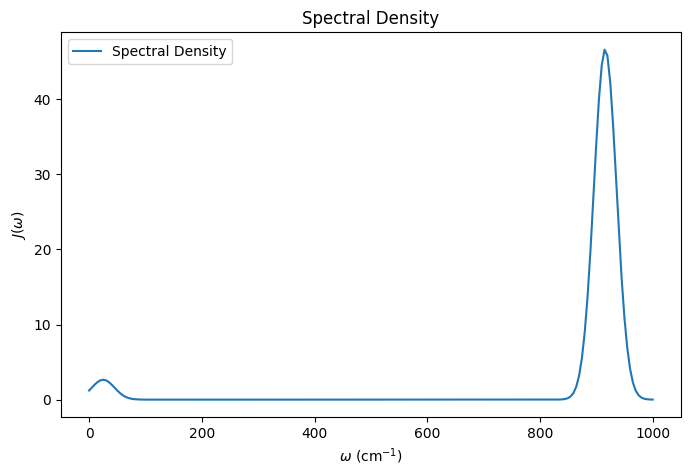

In [4]:
omega_range = np.linspace(0, 1000, 200)
sigma = 20

J_omega = np.zeros_like(omega_range)
for i in range(len(omega)):
    J_omega += (
        S[i]
        * (omega[i])
        * np.exp(-((omega_range - omega[i]) ** 2) / (2 * sigma**2))
    )

plt.figure(figsize=(8, 5))
plt.plot(omega_range, J_omega, label="Spectral Density")
plt.xlabel(r"$\omega$ (cm$^{-1}$)")
plt.ylabel(r"$J(\omega)$")
plt.title("Spectral Density")
plt.legend()
plt.show()

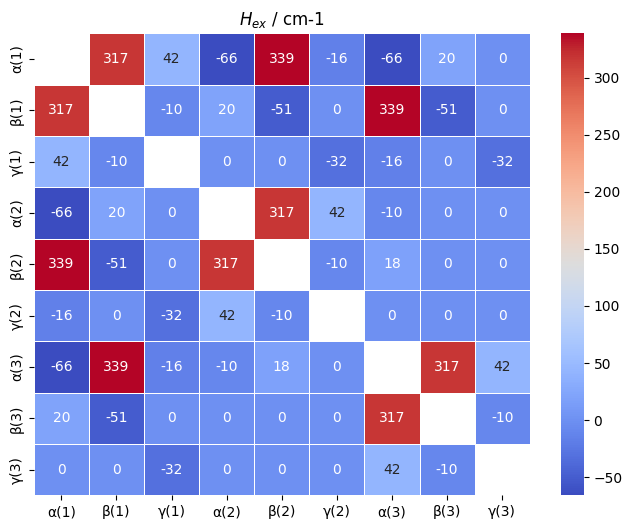

In [5]:
mat = np.zeros((9, 9), dtype=np.int64)

mat[0, 0] = mat[3, 3] = mat[6, 6] = α_cminv
mat[1, 1] = mat[4, 4] = mat[7, 7] = β_cminv
mat[2, 2] = mat[5, 5] = mat[8, 8] = γ_cminv
mat[0, 1] = mat[1, 0] = mat[3, 4] = mat[4, 3] = mat[6, 7] = mat[7, 6] = (
    αβ1_cminv
)
mat[1, 2] = mat[2, 1] = mat[4, 5] = mat[5, 4] = mat[7, 8] = mat[8, 7] = (
    βγ1_cminv
)
mat[0, 2] = mat[2, 0] = mat[3, 5] = mat[5, 3] = mat[6, 8] = mat[8, 6] = (
    αγ1_cminv
)
mat[0, 3] = mat[3, 0] = mat[0, 6] = mat[6, 0] = αα1_cminv
mat[1, 4] = mat[4, 1] = mat[1, 7] = mat[7, 1] = ββ1_cminv
mat[2, 8] = mat[8, 2] = mat[2, 5] = mat[5, 2] = γγ1_cminv
mat[3, 6] = mat[6, 3] = αα2_cminv
# mat[4,7] = mat[7,4] = ββ2_cminv
mat[0, 4] = mat[4, 0] = mat[1, 6] = mat[6, 1] = αβ2_cminv
mat[0, 5] = mat[5, 0] = mat[2, 6] = mat[6, 2] = αγ2_cminv
# mat[2,4] = mat[4,2] = mat[1,8] = mat[8,1] = βγ2_cminv
mat[0, 7] = mat[7, 0] = mat[3, 1] = mat[1, 3] = αβ3_cminv
mat[4, 6] = mat[6, 4] = αβ4_cminv


fig = plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    mat,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    linewidths=0.5,
    cbar=True,
    xticklabels=[
        "α(1)",
        "β(1)",
        "γ(1)",
        "α(2)",
        "β(2)",
        "γ(2)",
        "α(3)",
        "β(3)",
        "γ(3)",
    ],
    yticklabels=[
        "α(1)",
        "β(1)",
        "γ(1)",
        "α(2)",
        "β(2)",
        "γ(2)",
        "α(3)",
        "β(3)",
        "γ(3)",
    ],
    mask=np.eye(9),
)

plt.title(r"$H_{ex}$ / cm-1")
plt.show()

In [6]:
omega_syms = [sympy.Symbol(f"omega_{i}") for i in range(len(omega))]
S_syms = [sympy.Symbol(f"S_{i}") for i in range(len(omega))]

α = sympy.Symbol(r"E_{\alpha}")
β = sympy.Symbol(r"E_{\beta}")
γ = sympy.Symbol(r"E_{\gamma}")
αβ1 = sympy.Symbol(r"V_{\alpha\beta}^{1}")
αγ1 = sympy.Symbol(r"V_{\alpha\gamma}^{1}")
βγ1 = sympy.Symbol(r"V_{\beta\gamma}^{1}")
αα1 = sympy.Symbol(r"V_{\alpha\alpha}^{1}")
ββ1 = sympy.Symbol(r"V_{\beta\beta}^{1}")
γγ1 = sympy.Symbol(r"V_{\gamma\gamma}^{1}")
αβ2 = sympy.Symbol(r"V_{\alpha\beta}^{2}")
αγ2 = sympy.Symbol(r"V_{\alpha\gamma}^{2}")
# βγ2 = sympy.Symbol(r"V_{\beta\gamma}^{2}")
αα2 = sympy.Symbol(r"V_{\alpha\alpha}^{2}")
# ββ2 = sympy.Symbol(r"V_{\beta\beta}^{2}")
αβ3 = sympy.Symbol(r"V_{\alpha\beta}^{3}")
αβ4 = sympy.Symbol(r"V_{\alpha\beta}^{4}")


subs = {}
for omega_val, omega_sym, S_val, S_sym in zip(
    omega, omega_syms, S, S_syms, strict=True
):
    subs[omega_sym] = omega_val / units.au_in_cm1
    subs[S_sym] = S_val

subs[α] = α_cminv / units.au_in_cm1
subs[β] = β_cminv / units.au_in_cm1
subs[γ] = γ_cminv / units.au_in_cm1
subs[αβ1] = αβ1_cminv / units.au_in_cm1
subs[αγ1] = αγ1_cminv / units.au_in_cm1
subs[βγ1] = βγ1_cminv / units.au_in_cm1
subs[αα1] = αα1_cminv / units.au_in_cm1
subs[ββ1] = ββ1_cminv / units.au_in_cm1
subs[γγ1] = γγ1_cminv / units.au_in_cm1
subs[αβ2] = αβ2_cminv / units.au_in_cm1
subs[αγ2] = αγ2_cminv / units.au_in_cm1
# subs[βγ2] = βγ2_cminv / units.au_in_cm1
subs[αα2] = αα2_cminv / units.au_in_cm1
# subs[ββ2] = ββ2_cminv / units.au_in_cm1
subs[αβ3] = αβ3_cminv / units.au_in_cm1
subs[αβ4] = αβ4_cminv / units.au_in_cm1

### Setup basis for wavefunction

In [7]:
nmode = len(omega)
nmol = 9
nsite = (nmode + 1) * 3 * nmol
basis = []
for isite in range(nsite):
    if isite % (nmode + 1) == 0:
        basis.append(Exciton(nstate=2))
    else:
        basis.append(Boson(nstate=10))
basinfo = BasInfo([basis])
gamma_sites = [k for k in range(0, nsite, (nmode + 1) * 3)]
beta_sites = [k for k in range(nmode + 1, nsite, (nmode + 1) * 3)]
alpha_sites = [k for k in range((nmode + 1) * 2, nsite, (nmode + 1) * 3)]
sys_sites = [k for k in range(0, nsite, nmode + 1)]

### Setup one particle operator

In [8]:
q = basis[1].get_q_matrix()
num = basis[1].get_number_matrix()
adag = basis[0].get_creation_matrix()
a = basis[0].get_annihilation_matrix()
sz = np.diag([1.0, -1.0]) - np.eye(2)

In [9]:
a_ops = []
adag_ops = []
sz_ops = []
num_ops = []
q_ops = []

for isite in range(nsite):
    if isite % (nmode + 1) == 0:
        a_ops.append(OpSite("a_{" + f"{isite}" + "}", isite, value=a))
        adag_ops.append(
            OpSite(r"a^\dagger" + "_{" + f"{isite}" + "}", isite, value=adag)
        )
        sz_ops.append(OpSite(r"\sigma_{z," + f"{isite}" + "}", isite, value=sz))
        num_ops.append(None)
        q_ops.append(None)
    else:
        a_ops.append(None)
        adag_ops.append(None)
        sz_ops.append(None)
        num_ops.append(OpSite("N_{" + f"{isite}" + "}", isite, value=num))
        q_ops.append(OpSite("Q_{" + f"{isite}" + "}", isite, value=q))

### Setup potential and kinetic operator

In [10]:
sop = SumOfProducts()
for asite, bsite, gsite in zip(
    alpha_sites, beta_sites, gamma_sites, strict=True
):
    sop += -α / 2 * sz_ops[asite]
    # sop += α * adag_ops[asite] * a_ops[asite]
    sop += -β / 2 * sz_ops[bsite]
    # sop += β * adag_ops[bsite] * a_ops[bsite]
    sop += -γ / 2 * sz_ops[gsite]
    # sop += γ * adag_ops[gsite] * a_ops[gsite]
for isite in sys_sites:
    for k_mode, jsite in enumerate(range(isite + 1, isite + 1 + nmode)):
        sop += omega_syms[k_mode] * num_ops[jsite]
        sop += (
            omega_syms[k_mode]
            * sympy.sqrt(2 * S_syms[k_mode])
            * adag_ops[isite]
            * a_ops[isite]
            * q_ops[jsite]
        )
        # sop += -sympy.sqrt(S_syms[k_mode]/2) * sz_ops[isite] * q_ops[jsite]
for asite, bsite, gsite in zip(
    alpha_sites, beta_sites, gamma_sites, strict=True
):
    sop += αβ1 * adag_ops[bsite] * a_ops[asite]
    sop += αβ1 * a_ops[bsite] * adag_ops[asite]
    sop += αγ1 * adag_ops[gsite] * a_ops[asite]
    sop += αγ1 * a_ops[gsite] * adag_ops[asite]
    sop += βγ1 * adag_ops[gsite] * a_ops[bsite]
    sop += βγ1 * a_ops[gsite] * adag_ops[bsite]

nn_pairs = [
    (0, 2),
    (2, 4),
    (4, 6),
    (6, 7),
] + [(8, 7), (7, 5), (5, 1), (3, 0), (1, 0)]
for pair in nn_pairs:
    if max(pair) > nmol - 1:
        continue
    asite1 = alpha_sites[pair[0]]
    asite2 = alpha_sites[pair[1]]
    bsite1 = beta_sites[pair[0]]
    bsite2 = beta_sites[pair[1]]
    gsite1 = gamma_sites[pair[0]]
    gsite2 = gamma_sites[pair[1]]
    sop += αα1 * adag_ops[asite1] * a_ops[asite2]
    sop += αα1 * a_ops[asite1] * adag_ops[asite2]
    sop += ββ1 * adag_ops[bsite1] * a_ops[bsite2]
    sop += ββ1 * a_ops[bsite1] * adag_ops[bsite2]
    sop += γγ1 * adag_ops[gsite1] * a_ops[gsite2]
    sop += γγ1 * a_ops[gsite1] * adag_ops[gsite2]
    sop += αβ2 * adag_ops[bsite1] * a_ops[asite2]
    sop += αβ2 * a_ops[bsite1] * adag_ops[asite2]
    sop += αγ2 * adag_ops[gsite1] * a_ops[asite2]
    sop += αγ2 * a_ops[gsite1] * adag_ops[asite2]
    # sop += βγ2 * adag_ops[bsite1] * a_ops[gsite2]
    # sop += βγ2 * a_ops[bsite1] * adag_ops[gsite2]
    sop += αβ3 * adag_ops[asite1] * a_ops[bsite2]
    sop += αβ3 * a_ops[asite1] * adag_ops[bsite2]

skip_pairs = [
    (0, 4),
    (2, 6),
    (4, 8),
    (6, 8),
] + [(8, 5), (7, 3), (5, 3), (3, 1), (1, 2)]
for pair in nn_pairs:
    if max(pair) > nmol - 1:
        continue
    asite1 = alpha_sites[pair[0]]
    asite2 = alpha_sites[pair[1]]
    bsite1 = beta_sites[pair[0]]
    bsite2 = beta_sites[pair[1]]
    # gsite1 = gamma_sites[pair[0]]
    # gsite2 = gamma_sites[pair[1]]
    sop += αα2 * adag_ops[asite1] * a_ops[asite2]
    sop += αα2 * a_ops[asite1] * adag_ops[asite2]
    # sop += ββ2 * adag_ops[bsite1] * a_ops[bsite2]
    # sop += ββ2 * a_ops[bsite1] * adag_ops[bsite2]
    sop += αβ4 * adag_ops[bsite1] * a_ops[asite2]
    sop += αβ4 * a_ops[bsite1] * adag_ops[asite2]


sop = sop.simplify()
sop.symbol

-E_{\alpha}*\sigma_{z,15}/2 - E_{\alpha}*\sigma_{z,24}/2 - E_{\alpha}*\sigma_{z,33}/2 - E_{\alpha}*\sigma_{z,42}/2 - E_{\alpha}*\sigma_{z,51}/2 - E_{\alpha}*\sigma_{z,60}/2 - E_{\alpha}*\sigma_{z,69}/2 - E_{\alpha}*\sigma_{z,6}/2 - E_{\alpha}*\sigma_{z,78}/2 - E_{\beta}*\sigma_{z,12}/2 - E_{\beta}*\sigma_{z,21}/2 - E_{\beta}*\sigma_{z,30}/2 - E_{\beta}*\sigma_{z,39}/2 - E_{\beta}*\sigma_{z,3}/2 - E_{\beta}*\sigma_{z,48}/2 - E_{\beta}*\sigma_{z,57}/2 - E_{\beta}*\sigma_{z,66}/2 - E_{\beta}*\sigma_{z,75}/2 - E_{\gamma}*\sigma_{z,0}/2 - E_{\gamma}*\sigma_{z,18}/2 - E_{\gamma}*\sigma_{z,27}/2 - E_{\gamma}*\sigma_{z,36}/2 - E_{\gamma}*\sigma_{z,45}/2 - E_{\gamma}*\sigma_{z,54}/2 - E_{\gamma}*\sigma_{z,63}/2 - E_{\gamma}*\sigma_{z,72}/2 - E_{\gamma}*\sigma_{z,9}/2 + sqrt(2)*sqrt(S_0)*omega_0*a^\dagger_{0}*a_{0}*Q_{1} + sqrt(2)*sqrt(S_0)*omega_0*a^\dagger_{12}*a_{12}*Q_{13} + sqrt(2)*sqrt(S_0)*omega_0*a^\dagger_{15}*a_{15}*Q_{16} + sqrt(2)*sqrt(S_0)*omega_0*a^\dagger_{18}*a_{18}*Q_{19} + sqrt

### Setup MPO

In [11]:
am_pot = AssignManager(sop)
_ = am_pot.assign()
# W_prod = sympy.Mul(*am_pot.Wsym)
# assert W_prod[0] == sop.symbol, W_prod[0] - sop.symbol
# display(*am_pot.Wsym)
# (W_prod[0]-sop.symbol).simplify()

In [12]:
pot_mpo = am_pot.numerical_mpo(subs=subs)

In [13]:
pot_mpo_qr = []
r = np.eye(1)
eps = np.finfo(float).eps
for core in pot_mpo:
    i, j, k, l = core.shape
    h = r.shape[0]
    q, r = np.linalg.qr(
        np.einsum("hi,ijkl->hjkl", r, core).reshape(h * j * k, l),
        mode="reduced",
    )
    max_r = np.max(np.abs(r))
    r /= max_r
    nonzero_indices = ~np.all(np.abs(r) < eps, axis=1)
    q = q[:, nonzero_indices] * max_r
    r = r[nonzero_indices, :]
    m = q.shape[-1]
    pot_mpo_qr.append(q.reshape(h, j, k, m))
sign = np.sign(r[0, 0])
pot_mpo_qr[-1] *= sign
r *= sign
np.testing.assert_allclose(r, np.eye(1))

4
5
4
7
7
6
9
9
8
11
11
10
13
13
12
15
15
14
17
17
16
19
19
18
21
21
20
19
19
18
17
17
16
15
15
14
15
15
14
15
15
14
15
15
14
15
15
14
15
15
14
15
15
14
13
13
12
11
11
10
9
9
8
9
9
8
9
9
8
9
9
8
7
7
6
5
5
4
3
3
1


### Setup Hamiltonian

In [14]:
# MPO has legs on (0,1,2, ... ,f-1) sites. This legs are given by tuple key
potential = [
    [{tuple((k, k) for k in range(nsite)): TensorOperator(mpo=pot_mpo_qr)}]
]  # key is ((0,0), 1, 2, ..., ndim-1)

H = TensorHamiltonian(
    ndof=len(basis), potential=potential, kinetic=None, backend=backend
)

operators = {"hamiltonian": H}

core = np.zeros((1, 2, 1))
core[0, 1, 0] = 1.0
for idom, (asite, bsite, gsite) in enumerate(
    zip(alpha_sites, beta_sites, gamma_sites, strict=True)
):
    op = TensorHamiltonian(
        ndof=len(basis),
        potential=[[{(gsite,): TensorOperator(mpo=[core], legs=(gsite,))}]],
        kinetic=None,
        backend=backend,
    )
    operators[f"{idom}gamma"] = op
    op = TensorHamiltonian(
        ndof=len(basis),
        potential=[[{(bsite,): TensorOperator(mpo=[core], legs=(bsite,))}]],
        kinetic=None,
        backend=backend,
    )
    operators[f"{idom}beta"] = op
    op = TensorHamiltonian(
        ndof=len(basis),
        potential=[[{(asite,): TensorOperator(mpo=[core], legs=(asite,))}]],
        kinetic=None,
        backend=backend,
    )
    operators[f"{idom}alpha"] = op

core = np.zeros((1, 10, 1))
core[0, :, 0] = np.arange(10)
op = TensorHamiltonian(
    ndof=len(basis),
    potential=[[{(1,): TensorOperator(mpo=[core], legs=(1,))}]],
    kinetic=None,
    backend=backend,
)
operators["N1"] = op
# op = TensorHamiltonian(
#        ndof=len(basis),
#        potential=[[{(2,): TensorOperator(mpo=[core], legs=(2,))}]],
#        kinetic=None,
#        backend=backend,
# )
# operators[f"N2"] = op

# op = TensorHamiltonian(
#        ndof=len(basis),
#        potential=[[{(145,): TensorOperator(mpo=[core], legs=(145,))}]],
#        kinetic=None,
#        backend=backend,
# )
# operators[f"N145"] = op

### Setup Model (basis, operators, initial states)

In [15]:
model = Model(basinfo=basinfo, operators=operators)
model.m_aux_max = 4
# Starts from S1 state
boson_site = [1.0, 0.0] + [0.0] * (basis[1].nprim - 2)
gs_site = [1.0, 0.0]
ex_site = [0.0, 1.0]
initial_weights = []
for isite in range(nsite):
    if isite in [gamma_sites[0], gamma_sites[-1]]:
        initial_weights.append(ex_site)
    elif isite % (nmode + 1) == 0:
        initial_weights.append(gs_site)
    else:
        initial_weights.append(boson_site)

model.init_HartreeProduct = [initial_weights]
# initial_weights

### Execution

In [16]:
jobname = "lh2"
simulator = Simulator(jobname=jobname, model=model, backend=backend, verbose=2)
simulator.propagate(
    maxstep=100,
    stepsize=0.2,
    energy=True,
    autocorr=False,
    observables=True,
    observables_per_step=10,
    adaptive=True,
    adaptive_dD=40,
    adaptive_Dmax=40,
    adaptive_p_svd=1e-20,
    adaptive_p_proj=1e-09,
)

16:53:12 | INFO | Log file is ./lh2_prop/main.log
16:53:12 | WARNING | Adaptive calculation is experimental.
16:53:12 | INFO | Wave function is saved in wf_lh2.pkl
16:53:12 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:53:13 | INFO | End     0 step; propagated    0.200 [fs]; AVG Krylov iteration: 3.86
16:55:35 | INFO | End    99 step; propagated   19.800 [fs]; AVG Krylov iteration: 6.32
16:55:35 | INFO | End simulation and save wavefunction
16:55:36 | INFO | Wave function is saved in wf_lh2.pkl


(0.12165445329447924, <pytdscf.wavefunction.WFunc at 0x7f74f09cfa70>)

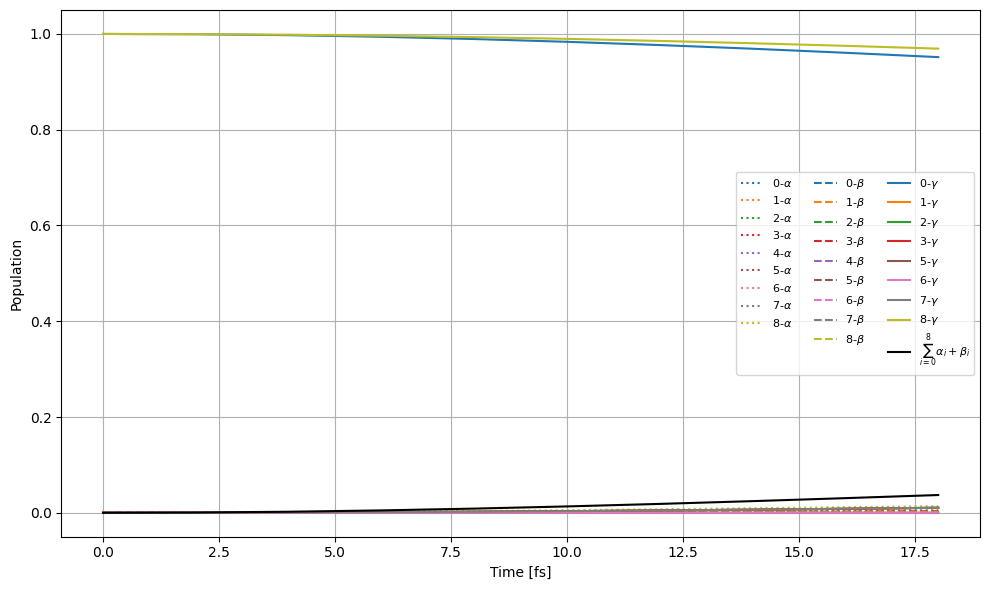

In [19]:
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import polars as pl

# path = sys.argv[1]
path = "lh2_prop/expectations.dat"

# mpl.style.use('seaborn-v0_8-colorblind')
# ]mpl.style.use('ggplot')
with open(path, "r") as f:
    header = f.readline().strip()
    columns = re.split(r"\s+", header)
    columns = [columns[1]] + columns[3:]
    data = f.readlines()

df = pl.read_csv(
    path,
    separator="\t",
    new_columns=columns,
    has_header=False,
    skip_rows=1,
    schema_overrides={col: pl.Float64 for col in columns},
)
# dump to excel
# df.write_csv("expectations.csv")

plt.figure(figsize=(10, 6))
ex_gamma = 4

for i in range(9):
    plt.plot(
        df["time"],
        df[f"{i}alpha"],
        label=f"{i}" + r"-$\alpha$",
        linestyle=":",
        color=f"C{i}",
    )
for i in range(9):
    plt.plot(
        df["time"],
        df[f"{i}beta"],
        label=f"{i}" + r"-$\beta$",
        linestyle="--",
        color=f"C{i}",
    )
for i in range(9):
    if i == ex_gamma:
        continue
    plt.plot(
        df["time"],
        df[f"{i}gamma"],
        label=f"{i}" + r"-$\gamma$",
        linestyle="-",
        color=f"C{i}",
    )

ab_sum = np.zeros(len(df["time"]))
for i in range(9):
    ab_sum += np.array(df[f"{i}alpha"]) + np.array(df[f"{i}beta"])

plt.plot(
    df["time"],
    ab_sum,
    label=r"$\sum_{i=0}^{8} \alpha_i + \beta_i$",
    linestyle="-",
    color="black",
)


plt.grid(True)
plt.xlabel("Time [fs]")
plt.ylabel("Population")
plt.tight_layout()
plt.legend(ncol=3, fontsize=8)
plt.savefig("exp.pdf")
plt.show()